In [16]:
import cv2 as cv
import numpy as np
import pandas as pd

In [10]:
DIFF_THRESHOLD = 0.3
PIXEL_THRESHOLD = 0.6

In [94]:
def calculate_statistics(ndvi_array, pixel_threshold=PIXEL_THRESHOLD, diff_threshold=DIFF_THRESHOLD):
    '''
    This function generate a dictionary counting the percentage of pixels for every
    NDVI graduations (keys of the dictionary) of a numpy array made of NDVI values
    (a value for every pixel).
    This function also computes the 'diff' value, it is the percentage of pixels with
    a low NDVI (less vegetation) near every high NDVI pixels (every pixel with more
    than pixel_threshold NDVI value).
    '''
    NDVIGraduation = {
        0 : 0, # <0.1
        1 : 0, # 0.1-0.2
        2 : 0, # 0.2-0.3
        3 : 0, # 0.3-0.4
        4 : 0, # 0.4-0.5
        5 : 0, # 0.5-0.6
        6 : 0, # 0.6-0.7
        7 : 0, # 0.7-0.8
        8 : 0, # 0.8-0.9
        9 : 0, # 0.9-1.0
        'diff' : 0 # Number of pixel with contrast (Forest-Desert, Forest-Cities, Forest-Soil)
    }

    shape = np.shape(ndvi_array)
    # Map values from 0-255 to 0-1
    temp = ndvi_array / 255.0
    # Calculate the number of pixels
    nofpixel = 1.0 * shape[0] * shape[1]
    
    for i, val in enumerate(np.histogram(temp[1:-1,1:-1], bins=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])[0]):
        NDVIGraduation[i] = val/nofpixel
     
    diff_10 = np.where((temp - np.roll(temp,shift=1,axis=0)) > diff_threshold,1,0)
    diff_11 = np.where((temp - np.roll(temp,shift=1,axis=1)) > diff_threshold,1,0)
    diff_array_thr = np.where( temp>pixel_threshold, diff_10+diff_11, 0)
    
    NDVIGraduation['diff'] = (diff_array_thr[1:-1,1:-1].sum())/nofpixel

    return NDVIGraduation

In [95]:
def calculateNDVI(image):
    '''
    This function calculates the NDVI (Normalized Difference
    Vegetation Index) for each pixel of the photo and collect
    these values in "ndvi" numpy array.
    '''
    # Extract bgr values
    b, _, r = cv.split(image)
    bottom = (r.astype(float) + b.astype(float))
    # Change zeros of bottom array  
    # (to make sure to not divide by zero)
    bottom[bottom == 0] = 0.0000000000001

    # Calculate NDVI value of each pixel
    ndvi = (r.astype(float) - b) / bottom
    
    ndvi = contrast_stretch(ndvi)
    ndvi = ndvi.astype(np.uint8)
    
    return ndvi

In [102]:
def contrast_stretch(im):
    '''
    Performs a simple contrast stretch of the given image, from 5-100%.
    '''
    in_min = np.percentile(im, 0)
    in_max = np.percentile(im, 100)

    out_min = 0.0
    out_max = 255.0

    out = im - in_min
    out *= ((out_min - out_max) / (in_min - in_max))
    out += in_min

    return out

In [103]:
csv_file = open('vegetation_new.csv', 'w')

header=['photo', 
        '<0.1', '<0.2', '<0.3',
        '<0.4', '<0.5', '<0.6',
        '<0.7', '<0.8', '<0.9',
        '<=1.0', 'diff']

csv_file.write(f"{','.join(header)}\n")

photo_list = [30,42,43,60,61,74,75,85,98,99]

for photo_counter in photo_list:
    
    print(f'Photo number {photo_counter}...')

    img = cv.imread("woodsmissionteam_img_" + str(photo_counter).zfill(3) +".png")
    
    ndvi = 255-calculateNDVI(img)

    cv.imwrite("woodsmissionteam_img_" + str(photo_counter).zfill(3) +"_NDVI.png",ndvi)

    ndvi_color = cv.applyColorMap(ndvi, cv.COLORMAP_JET)

    cv.imwrite("woodsmissionteam_img_" + str(photo_counter).zfill(3) +"_NDVI_COLOR_JET.png", ndvi_color)
    
    stats = list(calculate_statistics(ndvi).values())
    str_stats = ','.join(list(map(str, stats)))
    
    csv_file.write(f'{photo_counter}, {str_stats}\n')
    
    if photo_counter==75 or photo_counter==98:
        
        print(f'Photo number {photo_counter} (tagliata)...')
        
        img = cv.imread("woodsmissionteam_img_" + str(photo_counter).zfill(3) +"_tagliata.png")
        
        ndvi = 255-calculateNDVI(img)

        cv.imwrite("woodsmissionteam_img_" + str(photo_counter).zfill(3) +"_NDVI_tagliata.png",ndvi)

        ndvi_color = cv.applyColorMap(ndvi, cv.COLORMAP_JET)

        cv.imwrite("woodsmissionteam_img_" + str(photo_counter).zfill(3) +"_NDVI_COLOR_JET.png", ndvi_color)
        
        stats = list(calculate_statistics(ndvi).values())
        
        str_stats = ','.join(list(map(str, stats)))

        csv_file.write(f'{photo_counter}, {str_stats}\n')
        
print('Complete')

csv_file.close()

Photo number 30...
Photo number 42...
Photo number 43...
Photo number 60...
Photo number 61...
Photo number 74...
Photo number 75...
Photo number 75 (tagliata)...
Photo number 85...
Photo number 98...
Photo number 98 (tagliata)...
Photo number 99...
Complete


In [104]:
veg_df = pd.read_csv('vegetation_new.csv', index_col=0)
veg_df

,<0.1,<0.2,<0.3,<0.4,<0.5,<0.6,<0.7,<0.8,<0.9,<=1.0,diff
photo,,,,,,,,,,,
30,0.023687,0.260344,0.212795,0.369057,0.089215,0.020827,0.015252,0.006715,0.000195,1.101034e-06,1.981862e-06
42,0.001876,0.002161,0.020477,0.101186,0.110577,0.154264,0.247839,0.318664,0.030085,1.097473e-02,3.041236e-06
43,0.004667,0.027647,0.011304,0.045728,0.826459,0.058905,0.022377,0.001014,0.000002,0.000000e+00,8.689245e-07
60,0.015251,0.235786,0.549254,0.093783,0.009149,0.026079,0.041935,0.024440,0.002405,1.312253e-05,2.077734e-04
61,0.011824,0.160006,0.264760,0.416689,0.063617,0.030702,0.026709,0.017839,0.005722,2.281134e-04,1.506904e-04
74,0.006293,0.046456,0.082912,0.125284,0.499968,0.190162,0.032495,0.013486,0.001048,2.172311e-07,2.172311e-07
75,0.004275,0.111138,0.108940,0.104758,0.306410,0.344736,0.016926,0.000207,0.000201,5.161353e-04,2.870786e-04
75,0.001673,0.006786,0.005644,0.003879,0.004193,0.006536,0.027271,0.887245,0.041369,1.350787e-02,8.754414e-05
85,0.036451,0.239451,0.197647,0.142285,0.164638,0.171293,0.018823,0.018970,0.008278,1.698476e-04,7.331550e-07


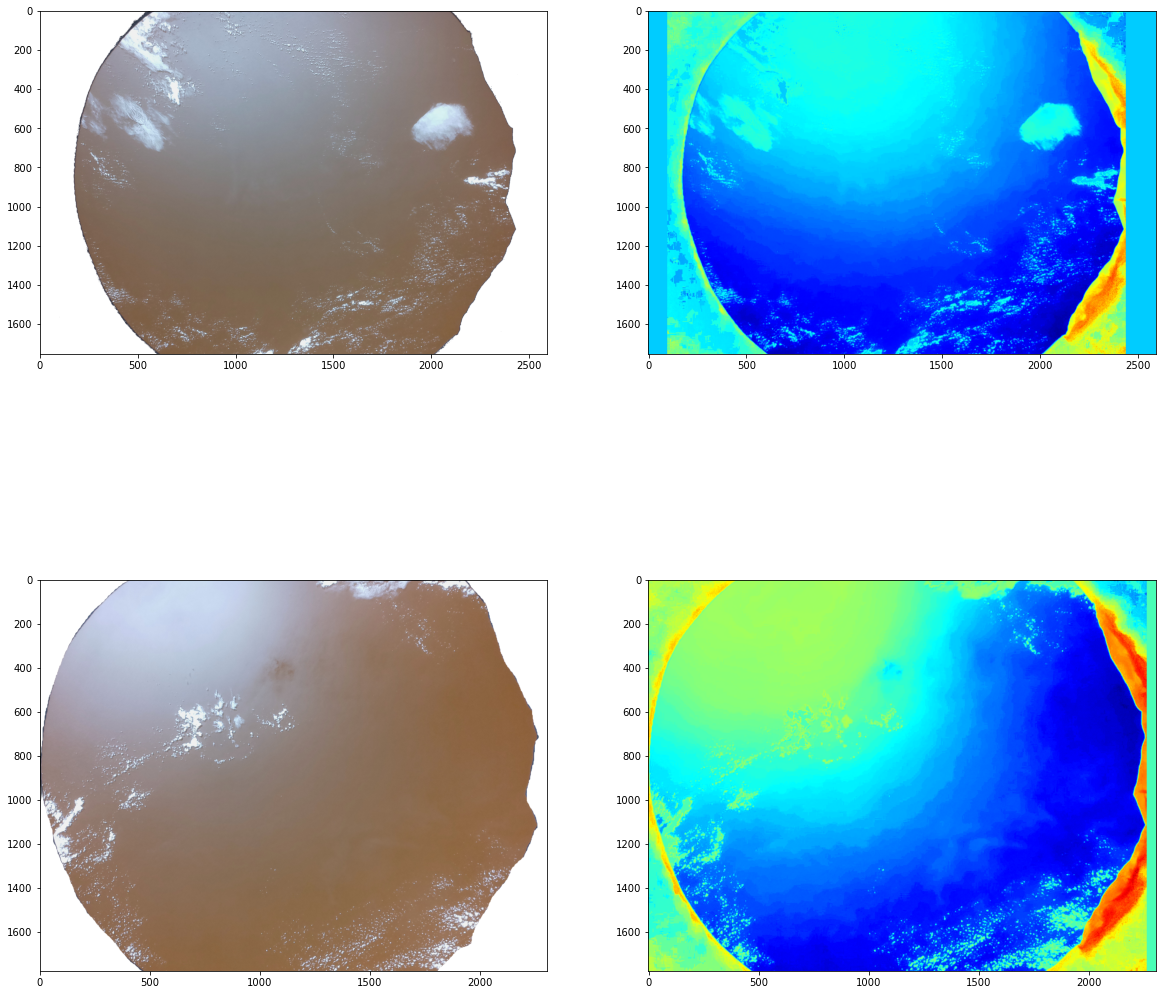

In [105]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('woodsmissionteam_img_030.png')

img_cm1 = mpimg.imread('woodsmissionteam_img_030_NDVI_COLOR_JET.png')

fig = plt.figure(figsize=(20,20))

a = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(img1)

a = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(img_cm1)

img2 = mpimg.imread('woodsmissionteam_img_085.png')

img_cm2 = mpimg.imread('woodsmissionteam_img_085_NDVI_COLOR_JET.png')

a = fig.add_subplot(2, 2, 3)
imgplot = plt.imshow(img2)

a = fig.add_subplot(2, 2, 4)
imgplot = plt.imshow(img_cm2)  

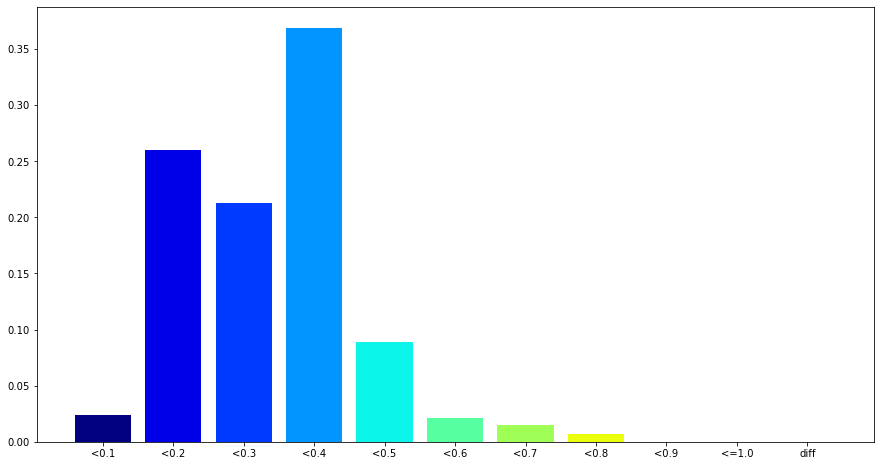

In [106]:
import numpy as np
from matplotlib import cm

labels = veg_df.columns
values = veg_df.loc[30].to_numpy(dtype=np.float64)

plt.figure(figsize=(15,8))

cm_jet = cm.get_cmap('jet')

np_index = np.arange(len(values))
#np_index = np_index[::-1]

plt.bar(labels, values, color=cm_jet(np_index/len(values)))

plt.show()

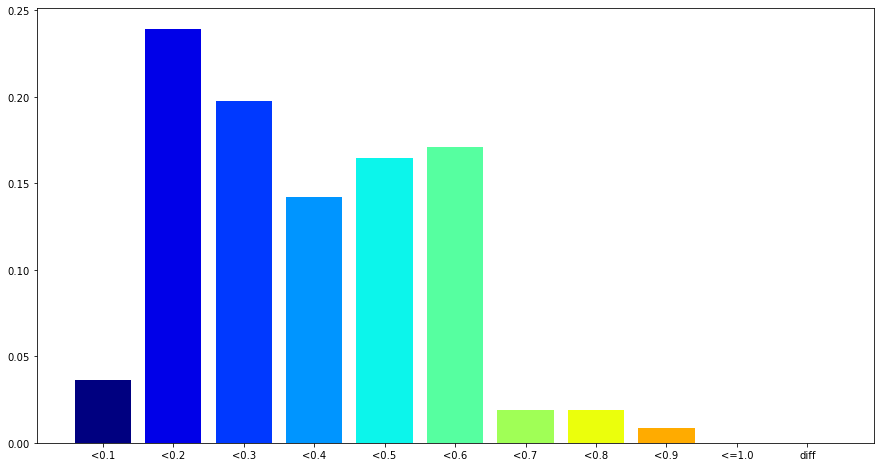

In [107]:
labels = veg_df.columns
values = veg_df.loc[85].to_numpy(dtype=np.float64)

plt.figure(figsize=(15,8))

cm_jet = cm.get_cmap('jet')

np_index = np.arange(len(values))
#np_index = np_index[::-1]

plt.bar(labels, values, color=cm_jet(np_index/len(values)))

plt.show()